In [21]:
import numpy as np
import torch
from torchsummary import summary
import os

import sys
sys.path.insert(1, 'src')

from network import BF_CNN
# from universal_inverse_solve import universal_inverse_solver

## Load Denoiser

In [22]:
# Load the denoiser architecture
denoiser = BF_CNN()

# Use GPU if available
if torch.cuda.is_available():
    denoiser = denoiser.cuda()

# Load the learned parameters
denoiser_path = os.path.join('denoisers','mnist.pt')

if torch.cuda.is_available():
    learned_params = torch.load(denoiser_path)
else:
    learned_params = torch.load(denoiser_path, map_location='cpu')

denoiser.load_state_dict(learned_params)

denoiser.eval()

# Show summary of the denoiser
summary(denoiser, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 64, 28, 28]          576
|    └─Conv2d: 2-2                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-3                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-4                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-5                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-6                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-7                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-8                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-9                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-10                      [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-11                      [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-12                      [-1

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 64, 28, 28]          576
|    └─Conv2d: 2-2                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-3                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-4                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-5                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-6                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-7                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-8                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-9                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-10                      [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-11                      [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-12                      [-1

# Synthesis

In [23]:
import numpy as np
import torch


def universal_inverse_solver(x_c, denoiser, sigma_0=1, sigma_L=0.01, h_0=0.01, beta=0.01):

    # M and M_T depend on the task we are performing, so input them as arguments depending on the task (ex infill)

    t = 1

    # For synthesis for now, M and M_T are just 0
    M = lambda x: torch.zeros_like(x)
    M_T = lambda x: torch.zeros_like(x)

    # N is the number of pixels in the image
    N = x_c.shape[2] * x_c.shape[1]

    # e is a matrix of 1's the shape of x_c
    e = torch.ones_like(M(x_c), requires_grad= False)

    # Draw y_0 from N(0.5 * (I - M^T M) e + M * x_c , sigma_0^2 * I)
    # y_t = torch.normal(0.5 * (torch.eye(x_c.shape[0]) - M_T(M(e))) + M(x_c), sigma_0 ** 2 * torch.eye(x_c.shape[0]))
    y_t = torch.normal((e - M(M_T(e)))/2 + M(x_c), sigma_0)
    y_t = y_t.unsqueeze(0)
    y_t.requires_grad = False

    f = denoiser(y_t)
    sigma = torch.norm(f)/np.sqrt(N)

    print(sigma, sigma_L)
    print(sigma >sigma_L)

    # max_count = 100

    while sigma > sigma_L:

        print(f'Sigma: {sigma}, t: {t}, Sigma_L {sigma_L}')

        # Step size
        h_t = h_0 * t / (1 + h_0 * (t - 1))

        # Denoised image
        #  f(y_t) = x^ (y) - y
        # Denoised is the output of the denoiser - the original image
        f = denoiser(y_t)

        # d_t = (I - M M^T) f(y_t) + M (x_c - M^T y_t) 
        d_t = f - M(M_T(f[0])) + M(M_T(y_t[0])) - M(x_c)

        # sigma_t = sqrt(abs(d_t)^2/N)

        sigma = torch.norm(d_t)/np.sqrt(N)

        # gamma_t = sqrt((1 beta * h_t)^2 - (1 - h_t)^2) * sigma_t^2)
        gamma_t = np.sqrt((1 - beta * h_t) ** 2 - (1 - h_t) ** 2) * sigma

        # Draw z_t from N(0, I)
        # z_t = torch.normal(0, 1)
        z_t = torch.randn(1, x_c.shape[2], x_c.shape[1])

        y_t = y_t - h_t * d_t + gamma_t * z_t

        t += 1

    return y_t - denoiser(y_t)



tensor(0.9695, grad_fn=<DivBackward0>) 0.01
tensor(True)
Sigma: 0.969451367855072, t: 1, Sigma_L 0.01
Sigma: 0.969451367855072, t: 2, Sigma_L 0.01
Sigma: 0.9721242189407349, t: 3, Sigma_L 0.01
Sigma: 0.9748350381851196, t: 4, Sigma_L 0.01
Sigma: 0.9862044453620911, t: 5, Sigma_L 0.01
Sigma: 0.9913339614868164, t: 6, Sigma_L 0.01
Sigma: 0.9848958849906921, t: 7, Sigma_L 0.01
Sigma: 0.982536256313324, t: 8, Sigma_L 0.01
Sigma: 0.9748967885971069, t: 9, Sigma_L 0.01
Sigma: 0.9957767128944397, t: 10, Sigma_L 0.01
Sigma: 1.003604531288147, t: 11, Sigma_L 0.01
Sigma: 1.0099624395370483, t: 12, Sigma_L 0.01
Sigma: 1.013098955154419, t: 13, Sigma_L 0.01
Sigma: 1.0206472873687744, t: 14, Sigma_L 0.01
Sigma: 1.0331599712371826, t: 15, Sigma_L 0.01
Sigma: 1.0533653497695923, t: 16, Sigma_L 0.01
Sigma: 1.051714539527893, t: 17, Sigma_L 0.01
Sigma: 1.0361632108688354, t: 18, Sigma_L 0.01
Sigma: 1.0253268480300903, t: 19, Sigma_L 0.01
Sigma: 1.0064043998718262, t: 20, Sigma_L 0.01
Sigma: 1.012909173

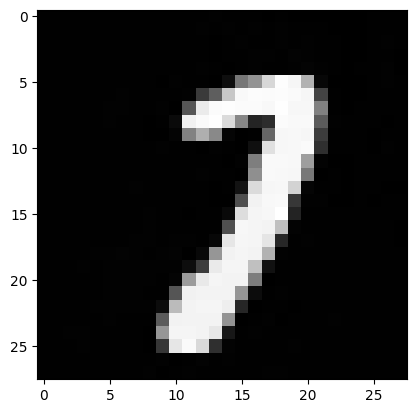

In [24]:
# For synthesis, both M and M_T are zero like or shape sample image
# Images are mnist, so 28x28
# Create a Tensor of zeros with the same shape as the sample image

# Input image is 28x28 of zeros and noise will be added to it
# This will be synthesized by the denoiser
patch_size = (1, 28, 28) # 1 channel, 28x28
x_c = torch.zeros(patch_size) 

synth = universal_inverse_solver(x_c, denoiser)

# Reshape the synthesized image to be 28x28
synth = synth.view(1,1,28,28)

# Show synthesized image
import matplotlib.pyplot as plt
plt.imshow(synth[0,0,:,:].detach().numpy(), cmap='gray')
plt.show()